# Coffee Leaf Diseases Prediction

## Overview
This notebook is a reproduction of the coffee leaf disease classification method described in the research paper below, using machine learning techniques with RGB and CMY color features.

## References

### Research Paper
- **Title**: Comparative Analysis of the Performance of the Decision Tree and K-Nearest Neighbors Methods in Classifying Coffee Leaf Diseases
- **Authors**: Adie Suryadi, Murhaban Murhaban, Rivansyah Suhendra
- **Published in**: Department of Information Technology, Teuku Umar University, Indonesia
- **URL**: [https://aptikom-journal.id/conferenceseries/article/view/649/272](https://aptikom-journal.id/conferenceseries/article/view/649/272)

### Dataset
- **Dataset**: Coffee Leaf Diseases
- **Source**: Kaggle
- **URL**: [https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code](https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code)

## Methodology
This implementation extracts color-based features from coffee leaf images:
- **RGB features**: Mean and standard deviation for each R, G, B channel (6 features)
- **CMY features**: Mean and standard deviation for each C, M, Y channel (6 features)
- **Total**: 12 color-based features per image

The features are then used to classify coffee leaves into four categories:
- Miner
- Phoma
- Rust
- No disease

## Preprocessing Data

In [ ]:
import numpy as np
from PIL import Image
import os

def rgb_to_cmy(rgb_image):
    # CMY = 1 - RGB
    cmy_image = 1.0 - rgb_image
    return cmy_image

def extract_color_features(image):
    features = []
    
    # RGB features (6)
    for channel in range(3):  # R, G, B
        channel_data = image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    # CMY features (6)
    cmy_image = rgb_to_cmy(image)
    for channel in range(3):  # C, M, Y
        channel_data = cmy_image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    return np.array(features)

def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img_resized = img.resize((410, 205)) # resize to 410x205
            img_array = np.array(img_resized).astype('float32') / 255.0 # normalize 
            
            features = extract_color_features(img_array)
            features_list.append(features)
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    
    return features_array, labels

def convert_to_single_label(row):
    if row['miner'] == 1:
        return 'miner'
    elif row['phoma'] == 1:
        return 'phoma'
    elif row['rust'] == 1:
        return 'rust'
    else:
        return 'nodisease'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import pandas as pd

train_label_df = pd.read_csv('dataset/train_classes.csv')
train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)

train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, 
    train_labels['label'],
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=123
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 21)) + [None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10)
grid_search_dt.fit(X_train_scaled, y_train)

best_model_dt = grid_search_dt.best_estimator_
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

# ---------- KNN ----------
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': range(1, 21),
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)
grid_search_knn.fit(X_train_scaled, y_train)

best_model_knn = grid_search_knn.best_estimator_
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

The best model for Decision Tree goes with below parameter:
- criterion: 'gini'
- max_depth: 14
- min_samples_leaf: 1
- min_samples_split: 2

The best model for KNN goes with below parameter:
- metric: 'euclidean'
- n_neighbors: 1

## Find the Best Model
### Using the parameters described in the paper

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---------- Decision Tree ----------
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=123,
    splitter='best'
)
dt.fit(X_train_scaled, y_train)
y_pred_valid_dt = dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))

# ---------- KNN ----------
knn = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform'
)
knn.fit(X_train_scaled, y_train)
y_pred_valid_knn = knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.8142292490118577
Precision (micro): 0.8142292490118577
Recall (micro): 0.8142292490118577
F1-score (micro): 0.8142292490118577
Precision (macro): 0.8128058414763226
Recall (macro): 0.8032373328425959
F1-score (macro): 0.8052358752725065


#### Confusion Matrix Heatmap

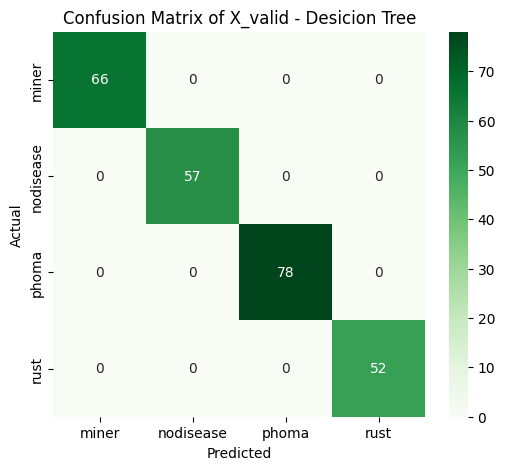

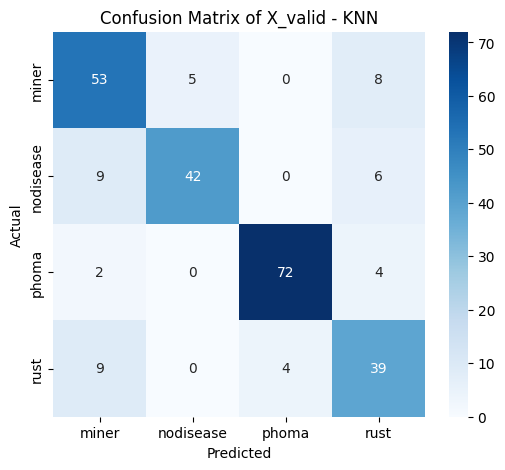

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_valid.unique())

# Desicion Tree
cm_valid_dt = confusion_matrix(y_valid, y_pred_valid_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - Desicion Tree')
plt.show()

# KNN
cm_valid_knn = confusion_matrix(y_valid, y_pred_valid_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - KNN')
plt.show()

### Using the best parameters from CV

In [10]:
# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


#### Confusion Matrix Heatmap

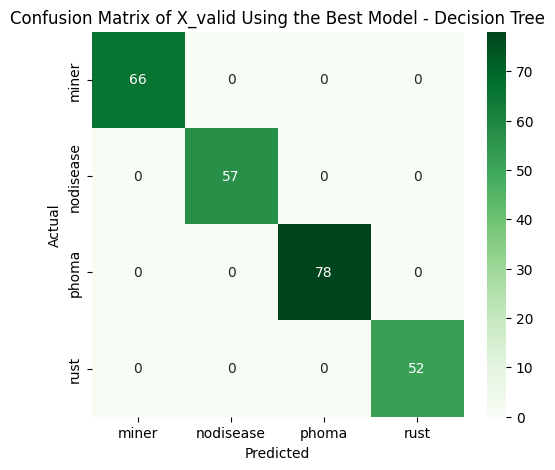

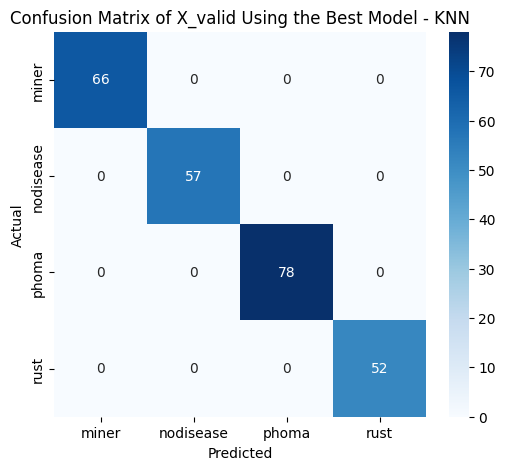

In [11]:
# Decision Tree
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - Decision Tree')
plt.show()

# KNN
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - KNN')
plt.show()